# Objectives

Identify the main topic/s from texts from a news database. The news are in English and are classified in 5 main topics.

This notebook trains 2 main models:

- A supervised one as a multi-classifier able to assign each document/text with one of the 5 topics.

- An unsupervised one ignoring the labels. Supose we have obtained a set of documents(texts) and we want to classify them by topics (topic modeling). The result will be a proposed grouping by topics (cluster) that will allow to identify the most important elements from each group. The number of topics or groups for this task are some of the parameters that need to be set.
  - KNN
  - LSA
  - LDA

In [1]:
!sudo pip3 install -U spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!python -m spacy download en_core_web_lg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 9.5 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


Make sure to restrart the runtime environment after downloading some packages.

In [1]:
# IMPORTS
import time
import glob
import numpy as np
import pandas as pd

from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
# Set google drive and load data
# Make sure to setup the correct path
drive.mount('/content/drive', force_remount=True)
sst_home = 'drive/My Drive/Topic Recognition'
sst_data = sst_home + '/bbc-train/'
sst_data_test = sst_home + '/bbc-test/'

Mounted at /content/drive


# 1. SUPERVISED MODEL

# Data gathering

In [3]:
sst_datas = [
             sst_data+'business',
             sst_data+'entertainment',
             sst_data+'politics',
             sst_data+'sports',
             sst_data+'tech',
]

sst_datas_test = [
                  sst_data_test+'business',
                  sst_data_test+'entertainment',
                  sst_data_test+'politics',
                  sst_data_test+'sports',
                  sst_data_test+'tech',
]

Since the data is given in an unconventional way, meaning, a .txt file for each document and each topi (class) has its corresponding folder. Also, some files are byte and not string for some reason. This process has to be done in order to create an actual dataset that can be processed and used to train/predict a model.

In [12]:
# Loop through each folder, gather data appending each
# file(text object) and label with the corresponding topic.
def gather_data_from_folders(folder_path_dict):
  df = pd.DataFrame()

  for i in range(0, len(folder_path_dict)):
    list_of_files = sorted(glob.glob(folder_path_dict[i]+'/*', recursive=True) )
    for filename in list_of_files:
      data = {"Text": "", "Label": 0}
      try:
        with open(filename, 'rb') as f:
          text = ""
          for line in f:
              text += " "+ line.decode("utf-8")
          data["Text"] = text
          data["Label"] = int(i)
          df = df.append(data, ignore_index=True)
      except:
        with open(filename, 'rb') as f:
          print(f.read())
          text = ""
          for line in f:
              text += " "+ line.decode("utf-16")
          data["Text"] = text
          data["Label"] = int(i)
          df = df.append(data, ignore_index=True)
    
    print(len(df))

  return df

In [13]:
df = gather_data_from_folders(sst_datas)
df_test = gather_data_from_folders(sst_datas_test)

460
816
1193
b'Chelsea sack Mutu\n\nChelsea have sacked Adrian Mutu after he failed a drugs test.\n\nThe 25-year-old tested positive for a banned substance - which he later denied was cocaine - in October. Chelsea have decided to write off a possible transfer fee for Mutu, a \xa315.8m signing from Parma last season, who may face a two-year suspension. A statement from Chelsea explaining the decision read:"We want to make clear that Chelsea has a zero tolerance policy towards drugs." Mutu scored six goals in his first five games after arriving at Stamford Bridge but his form went into decline and he was frozen out by coach Jose Mourinho. Chelsea\'s statement added: "This applies to both performance-enhancing drugs or so-called \'recreational\' drugs. They have no place at our club or in sport. "In coming to a decision on this case, Chelsea believed the club\'s social responsibility to its fans, players, employees and other stakeholders in football regarding drugs was more important than

In [14]:
df.head()

,Text,Label
0,Ad sales boost Time Warner profit\n \n Quarte...,0.0
1,Dollar gains on Greenspan speech\n \n The dol...,0.0
2,Yukos unit buyer faces loan claim\n \n The ow...,0.0
3,High fuel prices hit BA's profits\n \n Britis...,0.0
4,Pernod takeover talk lifts Domecq\n \n Shares...,0.0


In [30]:
df_test.head()

,Text,Label
0,US trade gap hits record in 2004\n \n The gap...,0.0
1,Yukos loses US bankruptcy battle\n \n A judge...,0.0
2,Safety alert as GM recalls cars\n \n The worl...,0.0
3,"Steel firm 'to cut' 45,000 jobs\n \n Mittal S...",0.0
4,Strong demand triggers oil rally\n \n Crude o...,0.0


In [31]:
# Randomly shuffle rows
df = df.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)

In [32]:
y_train = df["Label"]
train_df = df["Text"]
y_test = df_test["Label"]
test_df = df_test["Text"]

# Class distribution plot

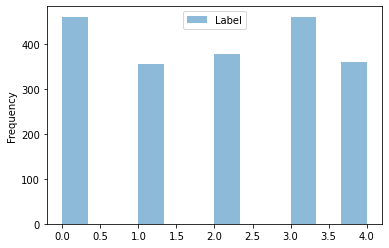

In [33]:
# Distribución de clases train
ax = df.plot.hist(bins=12, alpha=0.5)

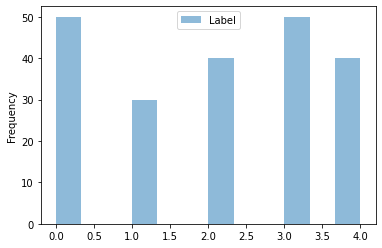

In [34]:
# Distribución de clases test
ax_test = df_test.plot.hist(bins=12, alpha=0.5)

Data looks pretty balanced since there is not much of a difference between classes. For that, no data balancing processes will be needed.

# Data preparing

In [19]:
import spacy

nlp = spacy.load('en_core_web_lg')

# Data cleaning

Since we are working with text data, some pre-processing is needed in order to clean data and prepare it to be consumed by a model. The NLP library spaCy allows for quick data cleaning such as removing special characters, unnecessary words and stop words. Also, lemmatize words in order to avoid ambiguity.

In [35]:
def clean_dataset(dataset):
  clean_text = (dataset
      .apply(lambda text: " "
              .join(token.lemma_ for token in nlp(text) if
                    not token.is_punct
                    and not token.is_currency
                    and not token.is_digit
                    and not token.is_punct
                    and not token.is_oov
                    and not token.is_space
                    and not token.is_stop
                    and not token.like_num
                    and not token.pos_ == "PROPN")))

  X_df=[]
  for text in clean_text:
      token = nlp(text)
      X_df.append(token.vector)

  return X_df

In [36]:
X_train = clean_dataset(train_df)
X_test = clean_dataset(test_df)

print("TRAIN:", len(X_train), len(y_train))
print("TEST:", len(X_test), len(y_test))

TRAIN: 2015 2015
TEST: 210 210


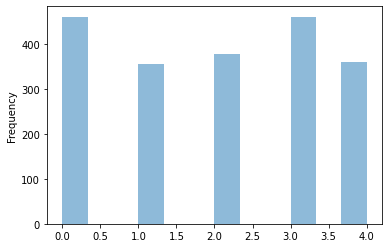

In [37]:
# Class distribution plot afer data preprocessing.
ax = y_train.plot.hist(bins=12, alpha=0.5)

# Supervised Model Training


Data visualization

In [38]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

**Decision tree**

In [41]:
from sklearn import tree

pipeline = Pipeline([
    ('classifier', tree.DecisionTreeClassifier()),
])

pipeline.fit(X_train,y_train)
predictions = pipeline.predict(X_test)

print( classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.81      0.88      0.85        50
         1.0       0.82      0.90      0.86        30
         2.0       0.87      0.85      0.86        40
         3.0       0.89      0.80      0.84        50
         4.0       0.92      0.90      0.91        40

    accuracy                           0.86       210
   macro avg       0.86      0.87      0.86       210
weighted avg       0.86      0.86      0.86       210



Decision tree plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


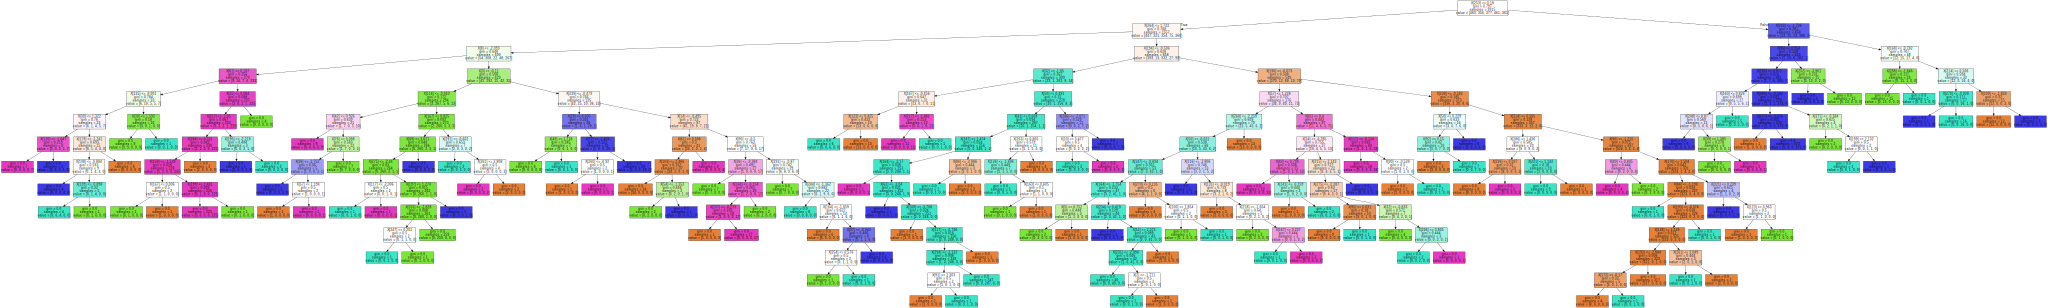

In [42]:
!pip install graphviz
import graphviz
# DOT data
dot_data = tree.export_graphviz(pipeline['classifier'], out_file=None, 
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

CPU times: user 3.15 s, sys: 91.1 ms, total: 3.24 s
Wall time: 6.35 s


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

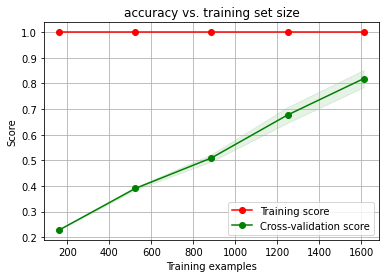

In [ ]:
%time plot_learning_curve(pipeline, "accuracy vs. training set size", X_train, y_train, cv=5)

**Random Forest**

In [45]:
from sklearn.ensemble import RandomForestClassifier


pipeline = Pipeline([
    ('classifier', RandomForestClassifier()),
])

pipeline.fit(X_train,y_train)
predictions = pipeline.predict(X_test)

print( classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.91      0.96      0.93        50
         1.0       1.00      0.97      0.98        30
         2.0       0.93      0.93      0.93        40
         3.0       1.00      0.98      0.99        50
         4.0       1.00      0.97      0.99        40

    accuracy                           0.96       210
   macro avg       0.97      0.96      0.96       210
weighted avg       0.96      0.96      0.96       210



CPU times: user 3.23 s, sys: 36.1 ms, total: 3.27 s
Wall time: 15.9 s


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

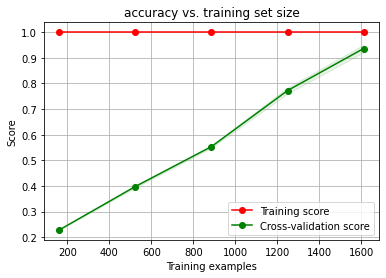

In [ ]:
%time plot_learning_curve(pipeline, "accuracy vs. training set size", X_train, y_train, cv=5)

**Confusion matrix**

In [3]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
from __future__ import absolute_import
import matplotlib.pyplot as plt
# Import scikit-plot
import scikitplot as skplt

In [47]:
predict_y = pipeline.predict(X_test) 
cm = confusion_matrix(y_test, predict_y)
cm

array([[48,  0,  2,  0,  0],
       [ 0, 29,  1,  0,  0],
       [ 3,  0, 37,  0,  0],
       [ 1,  0,  0, 49,  0],
       [ 1,  0,  0,  0, 39]])

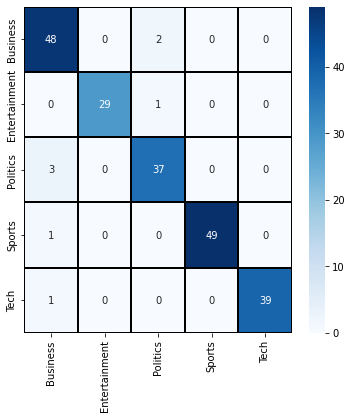

In [48]:
import seaborn as sns
cm = pd.DataFrame(cm , 
                  index = ['Business','Entertainment','Politics','Sports', 'Tech'],
                  columns = ['Business','Entertainment','Politics','Sports', 'Tech'])
plt.figure(figsize = (6,6))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black', linewidth = 1, annot = True,
            fmt='', xticklabels = ['Business','Entertainment','Politics','Sports', 'Tech'],
            yticklabels = ['Business','Entertainment','Politics','Sports', 'Tech'])

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['text', 'f', 'cm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


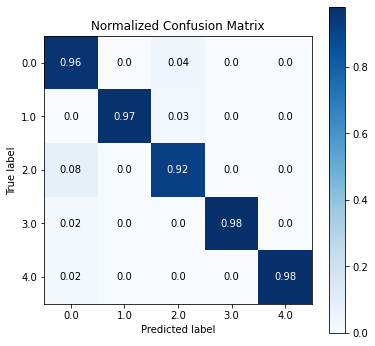

In [49]:
%pylab inline
pylab.rcParams['figure.figsize'] = (6, 6)
# Plot!
plot = skplt.metrics.plot_confusion_matrix(y_test, predict_y, normalize=True)

**ROC Curve**

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plot']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


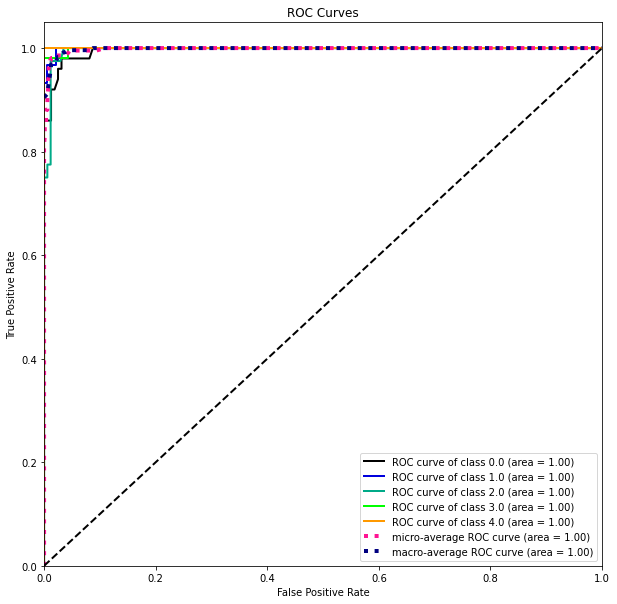

In [50]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 10)

# Get y_probabilities
y_probas = pipeline.predict_proba(X_test)

# Plot!
skplt.metrics.plot_roc_curve(y_test, y_probas, cmap='nipy_spectral')
plt.show()

# Result analysis and discussion

As we can see both from the classification report and the learning curve plot, the used supervised models prove good performance, specially Random forest. This model not only proved great overall accuracy but also very good performance when predicting every class without a significant difference.

The reasons for this model's success might be:

- Good data balancing
- spaCy's pre-processing capacity.
- Random oversampler's capacity to handle large datasets efficiently and produce predictions that can be understood easily. Finally, its algorithm provides a higher level of accuracy in predicting outcomes over the decision tree algorithm.

# 2. UNSUPERVISED MODEL TRAINING

# DISCUSION

From my research, the best unsupervised model for topic identification and classification is LDA (Latent Dirichlet Allocation).

Here are some links that will serve as justification and examples:

- https://www.analyticsvidhya.com/blog/2021/05/topic-modelling-in-natural-language-processing/ (Buena explicación)
- https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24 (EJEMPLO GENSIM)
- https://www.kaggle.com/code/thebrownviking20/topic-modelling-with-spacy-and-scikit-learn/notebook (EJEMPLO SPACY)


We continue using spaCy, to reduce notebook's load and standarize code. Also, it has an integrated LDA.

In [52]:
pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=a3792d567450a786baa72c87f4d2efee080da6d3182af4c03d6e76a78d3a2e54
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=a88585664d5c6e62d6d06c83cdf2a4e9ad8c173cfd4de40c6978a789f7b24bdc
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built pyLDAvis sklearn


In [53]:
# Usual imports
from tqdm import tqdm
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig
import pyLDAvis
# Plotly based imports for visualization
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


/usr/local/lib/python3.7/dist-packages/tornado/httputil.py:107: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working



In [56]:
# Firstly, we merge our datasets
df_raw_text = pd.concat([train_df, test_df], ignore_index=True)
df_raw_text = df_raw_text.sample(frac=1).reset_index(drop=True)
print(df_raw_text.size)

2225


In [57]:
# Repeat the cleaning process from the previous approach but 
# keep tokens (not vectors)
clean_text = (df_raw_text
    .apply(lambda text: " "
            .join(token.lemma_ for token in nlp(text) if
                  not token.is_punct
                  and not token.is_currency
                  and not token.is_digit
                  and not token.is_punct
                  and not token.is_space
                  and not token.is_stop
                  and not token.like_num)))

print(len(clean_text))
print(clean_text[0])
print(type(clean_text[0]))

2225
Protesters plan airport challenge campaigner expansion Britain airport begin challenge government plan High Court BAA expansion Stansted Airport Essex build extra runway fiercely oppose plan opponent 2bn cost new runway meet cash Heathrow Gatwick say illegal current rule try block government change legislation BAA owner airport Heathrow Gatwick say raise money need stansted upgrade current landing charge BAA say attempt involve community future airport plan group challenge plan include stop Stansted Expansion Heathrow anti noise campaigner HACAN Clearskies London borough Hillingdon Wandsworth opponent likely complain public consultation extra runway build Luton Airport change landing procedure Heathrow group win government future aviation plan outline year transport White Paper leave ruin campaigner government adequately consider building new airport plan Isle Sheppey east London Lord Hanningfield leader Essex County Council tell BBC Radio today programme go High Court want judge 

In [58]:
words_2_replace = ["year","say","add","good","time","want","like","new","set",
                   "think","tell","final","number","include","brown","work",
                   "come","make","people","Warner","told","world"]

df_filtered_text = clean_text.replace(to_replace =words_2_replace, 
                            value ="",regex=True)
print(df_filtered_text)

0       Protesters plan airport challenge campaigner e...
1       Thompson  Gerrard stay Liverpool legend Phil T...
2       citizenship event 18 tout citizenship ceremony...
3       Bangkok film festival battle Organisers Bangko...
4       Sony PSP console hit March gamer able buy Sony...
                              ...                        
2220    web log aid disaster recovery vivid descriptio...
2221    camera phone have  mobile camera sell Europe e...
2222    fear help France Laporte France coach Bernard ...
2223    Mobiles  visual radio growth mobile phone mark...
2224    medium seek Jackson juror note Reporters cover...
Name: Text, Length: 2225, dtype: object


In [60]:
vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english',
                             lowercase=True,
                             token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(df_filtered_text)

<>:3: DeprecationWarning:

invalid escape sequence \-

<>:3: DeprecationWarning:

invalid escape sequence \-

<>:3: DeprecationWarning:

invalid escape sequence \-

<ipython-input-60-602941ad8248>:3: DeprecationWarning:

invalid escape sequence \-



In [61]:
lda = LatentDirichletAllocation(n_components=5, max_iter=10,
                                learning_method='online',
                                verbose=True)
data_lda = lda.fit_transform(data_vectorized)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [62]:
def selected_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names_out()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])

# Visualización de resultados

In [63]:
# Keywords for topics clustered by Latent Dirichlet Allocation.
# With clean data.
print("LDA Model:")
selected_topics(lda, vectorizer)

LDA Model:
Topic 0:
[('government', 971.3376263077813), ('labour', 768.1064161157769), ('party', 735.0845648987131), ('election', 722.2425545306668), ('minister', 649.449207591483), ('plan', 605.3412400151027), ('blair', 574.8396122567499), ('country', 573.5605534566391), ('rise', 560.2646413801237), ('economy', 477.2829251121243)]
Topic 1:
[('win', 626.3042455551117), ('game', 574.682623328651), ('england', 524.1987980060304), ('play', 437.1265759710604), ('player', 431.7040414129436), ('team', 358.56429589662605), ('match', 347.7754015791601), ('wales', 345.5896700592756), ('ireland', 333.8182289609008), ('half', 303.9536720002724)]
Topic 2:
[('film', 1033.9199595203258), ('win', 683.9190934301222), ('play', 556.9001360982954), ('star', 519.4896701153942), ('award', 509.0034729175722), ('music', 380.09437505856323), ('game', 283.9971025326137), ('band', 279.4513446971929), ('day', 265.72546795939934), ('director', 257.18457217440584)]
Topic 3:
[('law', 410.8273521191985), ('court', 3

- Topic 0 --> Politics
- Topic 1 --> Tech
- Topic 2 --> Business
- Topic 3 --> Sports
- Topic 4 --> Entertainment

In [64]:
import pyLDAvis.sklearn

In [65]:
# https://github.com/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb
# https://nbviewer.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb
pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne')
dash

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning:

'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming o

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      150.222153  -72.269554       1        1  32.477597
4       51.163364 -159.968018       2        1  21.029511
2      -73.144554   21.523815       3        1  18.879412
1      -66.410133 -110.606438       4        1  14.683485
3       54.417324   12.443444       5        1  12.929994, topic_info=            Term         Freq        Total Category  logprob  loglift
2280        film  1101.000000  1101.000000  Default  30.0000  30.0000
6670         win  1453.000000  1453.000000  Default  29.0000  29.0000
2474        game  1410.000000  1410.000000  Default  28.0000  28.0000
3919      mobile   618.000000   618.000000  Default  27.0000  27.0000
6046  technology   637.000000   637.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
2278        file   146.126476   312.030028   Topic5  -5.7379   1.2870
2594  government   187.061115  1167.800660   Topic5  -5.4909   0.2142
2297        firm   177.718166  1023.188034   Topic5  -5.5421   0.2951
5240        rule   149.016918   393.286410   Topic5  -5.7183   1.0751
6445        user   152.487009   473.600870   Topic5  -5.6953   0.9123

[375 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
59        1  0.225402   action
59        2  0.104651   action
59        3  0.126118   action
59        4  0.128801   action
59        5  0.415921   action
...     ...       ...      ...
6738      2  0.987460     xbox
6740      2  0.994352    yahoo
6759      2  0.989402  yugansk
6761      2  0.995527    yukos
6764      4  0.994536  zealand

[790 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 3, 2, 4])

# Results Analysis

- The model returns decent results as we can see, it is classifying "key words" in the 5 topics that we know.

- The topics are not ordered in the same way as the ones labeled in the bcc-topic folder and the names are different. That being said, the distribution of key words between topics is pretty good. Ex: government, election and labour are in Topic 2 (politics), on the other hand, market, growth and sales are in Topic 4 (business). 
- There are still some irelevant words found in each topic group such as, "said". These can be deleted from the dataframe itself and run the model again to see if the results improve. Running the model multiple times is not an issue since it is very fast.

# LSA using GENSIM

In [66]:
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

/usr/local/lib/python3.7/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning:

`scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

**Data cleaning**

Tokenize and lematiza the text, remove stop words.

In [68]:
# This function is similar to the ones used in the previous approaches but has
# several particularities that only need to be considered for this one.
def preprocess_data(doc_set):
   
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    stopwordsEN = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    lematizador = WordNetLemmatizer()
    words_2_replace = ["said", "year","added","made","make","people","time",
                       "told","world","years","mr","would"]
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        stopped_tokens = [i for i in tokens if not i in stopwordsEN]
        stopped_tokens = [i for i in stopped_tokens if not i in words_2_replace]
        lemas = [lematizador.lemmatize(i) for i in stopped_tokens]
        texts.append(lemas)
    return texts

Function that creates a term dictionary that will be used in the document term matrix.

In [69]:
def prepare_corpus(doc_clean):
    # Create a dictionary without repeated words
    dictionary = corpora.Dictionary(doc_clean)
    # Creation of term matrix from previous dictionary
    term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    return dictionary, term_matrix

Function that creates an LSA model that groups words by topics. The optimal topic number is calculated in the **compute_coherence_values** function. THe model will show the number of words that represent each topic the most.

In [70]:
def create_lsa_gensim_model(doc_clean, nclusters, nwords):
   
    dictionary, term_matrix = prepare_corpus(doc_clean)
    # generate LSA model
    lsi = LsiModel(term_matrix, num_topics=nclusters, id2word = dictionary)  
    topics = lsi.print_topics(num_topics=nclusters, num_words=nwords)
    for t in range(lsi.num_topics):
        plt.figure()
        plt.imshow(WordCloud().fit_words(dict(lsi.show_topic(t, nwords))))
        plt.axis("off")
        plt.title("Topic #" + str(t))
        plt.show()
    return lsi

In order to optimize the results, it is necessary to try different LSA models with diferent cluster numbers. This function tries cluster combinations starting from 2 and ending at 12.

In [71]:
def calculate_coherence(dictionary, term_matrix, doc_clean, stop, start=2, step=3):
 
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(term_matrix, num_topics=num_topics, id2word = dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    return model_list, coherence_values

Function that plots a graphic that shows the degree of coherence of the different models with different cluster numbers.

In [72]:
def plot_graph(doc_clean,start, stop, step):
    dictionary, doc_term_matrix = prepare_corpus(doc_clean)
    model_list, coherence_values = calculate_coherence(dictionary, doc_term_matrix,
                                                       doc_clean, stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of clusters")
    plt.ylabel("Coherence")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

As we can see in the plot bellow, the most optimal number of clusters is 6. 

In [74]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

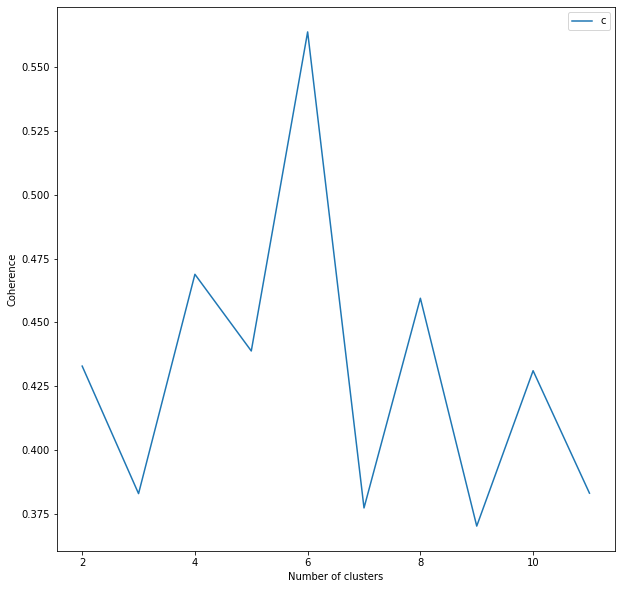

In [75]:
clean_text = preprocess_data(df_filtered_text)
start, stop, step = 2,12,1
plot_graph(clean_text, start, stop, step)

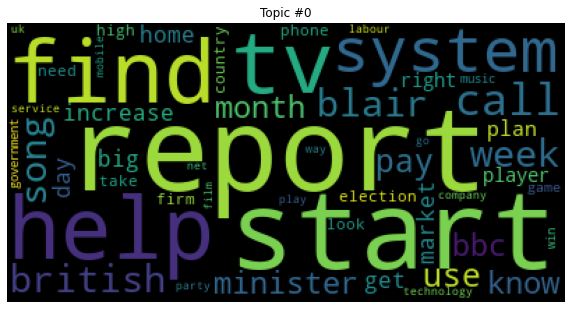

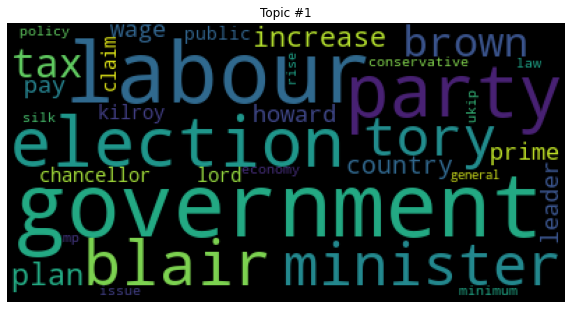

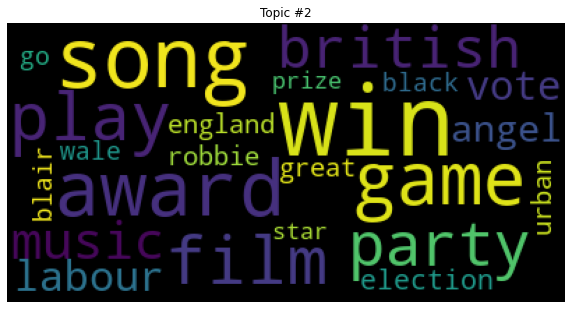

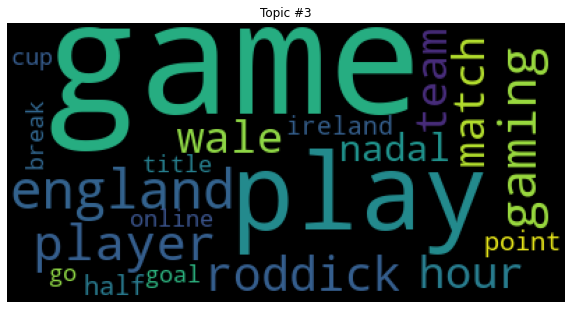

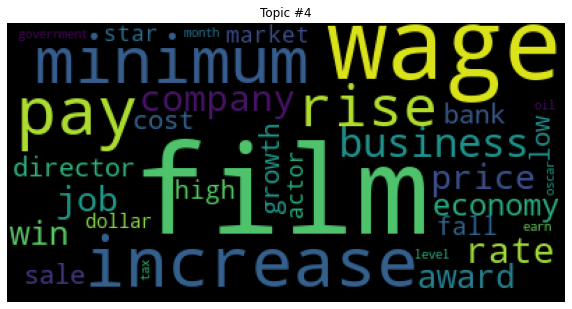

In [76]:
clusters=5
n_words=50

model=create_lsa_gensim_model(clean_text, clusters, n_words)
